In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim import corpora, models
import gensim
import numpy as np
from gensim.models import CoherenceModel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import operator
from sklearn.decomposition import NMF
from collections import defaultdict
import shutil
import os

path_to_allrecipes = 'archive/allrecipes-recipes.json.xz'
path_to_kaggle = 'archive/Food Ingredients and Recipe Dataset with Image Name Mapping.csv'
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Clean DataSet

In [2]:
def combine_datasets(path_to_kaggle, path_to_allrecipes):
    def read_file(path):
        recipes_lines = [json.loads(line) for line in open(path, 'r')]
        return pd.DataFrame(recipes_lines)

    df_all_recipies = pd.read_json(path_to_allrecipes,lines=True, compression='xz')
    df_all_recipies = df_all_recipies[df_all_recipies['photo_url'] != "http://images.media-allrecipes.com/global/recipes/nophoto/nopicture-910x511.png"]
    df_all_recipies = df_all_recipies[["ingredients", "instructions", "photo_url", "title"]]
    
    df_kaggle = pd.read_csv(path_to_kaggle)
    df_kaggle['Instructions'] = df_kaggle.apply(lambda x: [x.Instructions], axis=1)
    df_kaggle.rename(columns={"Title":"title", "Cleaned_Ingredients":"ingredients", "Instructions": "instructions", "Image_Name":"photo_url"}, inplace = True)
    df_kaggle = df_kaggle[["ingredients", "instructions", "photo_url", "title"]]
    final_df = pd.concat([df_all_recipies, df_kaggle])
    
    return final_df

def clean_dataset(dataset):
    def remove_values(x):
        prohibitedWords = [' and ', ' with ', ' the ', 'easy', 'best', ' i ', 'ii', 'iii', 'iv', 'quick']
        big_regex = re.compile('|'.join(map(re.escape, prohibitedWords)))
        l = [big_regex.sub(" ", str(t).lower()) for t in x]
        return l
    data = dataset.assign(recipe_name = lambda x: remove_values(x['title']))
    return data

def tokenize_words(data):
    de_stop = stopwords.words('english')
    tokenizer = RegexpTokenizer(r'\w+')
    final_names=[]
    recipe_name = data['recipe_name'].tolist()
    for rec in recipe_name:
        raw = rec.lower()
        tokens = tokenizer.tokenize(raw)
        stop_t = [recipe_name for recipe_name in tokens if not recipe_name in de_stop]
        stem_t = [i for i in stop_t if len(i)>1]
        if len(stem_t)==0: final_names.append(['error'])
        else: final_names.append(stem_t)
    return (recipe_name, final_names)


In [3]:
data = clean_dataset(combine_datasets(path_to_kaggle, path_to_allrecipes))
recipe_name, final_names = tokenize_words(data)

### Train LDA 

In [20]:
def build_dict_and_corpus(final_names):
    dictionary = corpora.Dictionary(final_names)
    corpus = [dictionary.doc2bow(text) for text in final_names]
    return (dictionary, corpus)

In [5]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

def train_lda(corpus, dictionary, final_names):
    num_topics = list(range(50,150,10))
    num_keywords = 15

    LDA_models = {}
    LDA_topics = {}
    for i in num_topics:
        print(i)
        LDA_models[i] = gensim.models.ldamodel.LdaModel(corpus, num_topics=i,passes=1, chunksize=len(corpus), random_state=0, id2word=dictionary)
        shown_topics = LDA_models[i].show_topics(num_topics=i, num_words=num_keywords, formatted=False)
        LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
    coherences = [CoherenceModel(model=LDA_models[i], texts=final_names, dictionary=dictionary, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]
    print("Coherences:", coherences)

    LDA_stability = {}
    for i in range(0, len(num_topics)-1):
        jaccard_sims = []
        for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
            sims = []
            for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
                sims.append(jaccard_similarity(topic1, topic2))    

            jaccard_sims.append(sims)    

        LDA_stability[num_topics[i]] = jaccard_sims

    mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]
    print("Mean Stabilities:", mean_stabilities)
    coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(len(num_topics[:-1]))] # limit topic numbers to the number of keywords
    coh_sta_max = max(coh_sta_diffs)
    coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
    ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
    ideal_topic_num = num_topics[ideal_topic_num_index]
    plt.figure(figsize=(20,10))
    ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
    ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

    ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
    ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

    y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
    ax.set_ylim([0, y_max])
    ax.set_xlim([1, num_topics[-1]-1])

    ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
    ax.set_ylabel('Metric Level', fontsize=20)
    ax.set_xlabel('Number of Topics', fontsize=20)
    plt.legend(fontsize=20)
    plt.show()   


50
60
70
80
90
100
110
120
130
140
Coherences: [0.2881875189693908, 0.27034217457012005, 0.2559300195894485, 0.287925915176533, 0.310625846108634, 0.34916380715752604, 0.318758752426189, 0.3658859692552004, 0.4209314126506291]
Mean Stabilities: [0.23028356427173458, 0.22478467243124764, 0.18433657978834198, 0.1517778391560064, 0.13130017980664208, 0.08986758290620331, 0.04245215212368896, 0.20285037477964288, 0.4655293860826805]


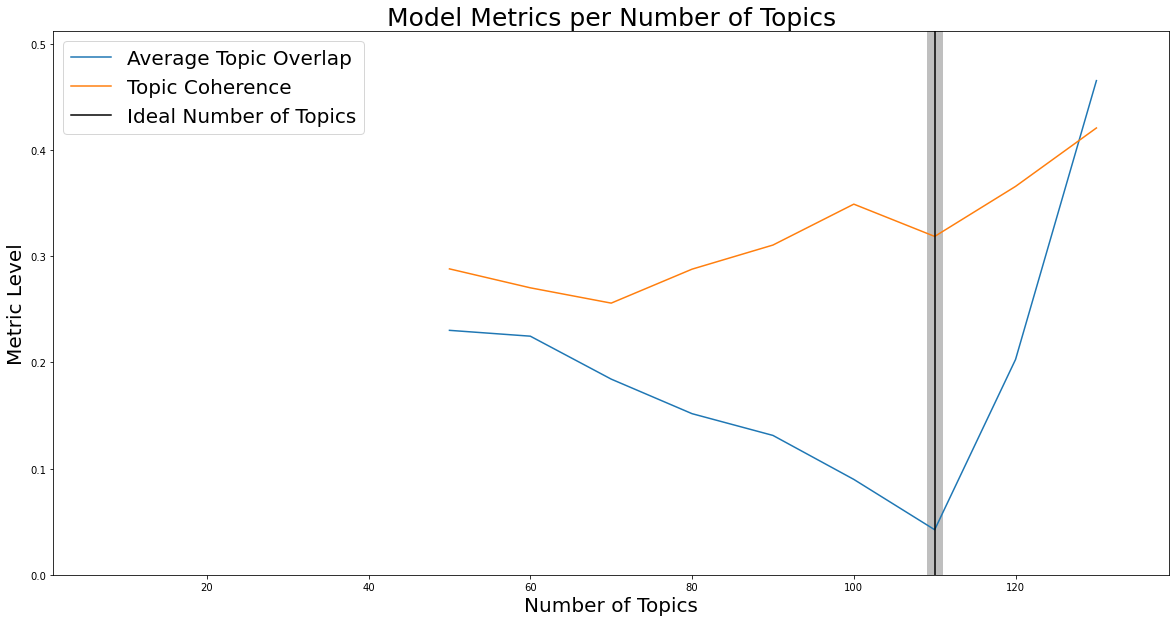

In [6]:
dictionary, corpus = build_dict_and_corpus(final_names)
train_lda(corpus, dictionary)

### Main LDA

In [9]:
def lda_model(corpus, num_of_topics, dictionary):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_of_topics, passes=1, chunksize=len(corpus), random_state=0, id2word=dictionary)
    return ldamodel

In [10]:
ldamodel = lda_model(corpus, 110, dictionary)
ldamodel.print_topics(num_topics=110,num_words = 15)

[(0,
  '0.022*"three" + 0.022*"pizza" + 0.022*"sausage" + 0.022*"skillet" + 0.022*"cheese" + 0.022*"style" + 0.022*"johnsonville" + 0.022*"chicken" + 0.022*"italian" + 0.011*"salad" + 0.011*"quinoa" + 0.011*"con" + 0.006*"sweet" + 0.006*"quesadillas" + 0.006*"shoot"'),
 (1,
  '0.013*"chicken" + 0.007*"pepper" + 0.007*"mole" + 0.007*"red" + 0.007*"fingerling" + 0.007*"parsley" + 0.007*"jerk" + 0.007*"cakes" + 0.007*"garlic" + 0.007*"jus" + 0.007*"ice" + 0.007*"eyed" + 0.007*"broccoli" + 0.007*"skillet" + 0.007*"anglaise"'),
 (2,
  '0.007*"halibut" + 0.007*"coconut" + 0.007*"italian" + 0.007*"braised" + 0.007*"cheese" + 0.007*"sausage" + 0.007*"three" + 0.007*"skillet" + 0.007*"lemongrass" + 0.007*"chutney" + 0.007*"ginger" + 0.007*"eggplant" + 0.007*"fillets" + 0.007*"pizza" + 0.007*"style"'),
 (3,
  '0.019*"potato" + 0.012*"bacon" + 0.012*"sausage" + 0.012*"skillet" + 0.012*"italian" + 0.006*"crumbs" + 0.006*"pizza" + 0.006*"pancakes" + 0.006*"medley" + 0.006*"tomatoes" + 0.006*"bisque

### TFIDF

In [29]:
def tfidf_model(final_names):
    data_samples = [' '.join(ti) for ti in final_names]
    tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=None)
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    return (tfidf, tfidf_feature_names, data_samples)

In [25]:
def rank_terms(A, terms):
    sums = A.sum(axis=0)
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

def visualize_topics(ranking):
    topic_n = []
    for i, pair in enumerate(ranking[0:10]):
        topic_n.append(pair[0])
        print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1]))

In [30]:
tfidf, tfidf_feature_names, data_samples = tfidf_model(final_names)
ranking = rank_terms(tfidf, tfidf_feature_names)
topic_n = visualize_topics(ranking)

01. chicken (2272.10)
02. salad (1798.09)
03. chocolate (1270.53)
04. cake (1231.05)
05. pie (1133.84)
06. soup (1127.89)
07. cheese (1058.56)
08. sauce (1028.70)
09. cookies (1024.20)
10. bread (901.91)


### NMF

In [75]:
def nmf(num_comp, tfidf, final_names):
    nmf = NMF(n_components=num_comp, random_state=1, verbose=1, max_iter=200).fit(tfidf)
    nmf_emb = nmf.transform(tfidf)
    top_idx = np.argsort(nmf_emb,axis=0)[-1:]
    show_ten = num_comp+1
    count_idxs = 0
    final_topics = []
    for idxs in top_idx.T:
        if count_idxs == show_ten: break
        for idx in idxs:
            final_topics.append(final_names[idx])
        count_idxs += 1
    return (nmf, nmf_emb, final_topics)

In [76]:
def print_top_words(model, feature_names, n_top_words):
    manual_topic_cat = []
    for topic_idx, topic in enumerate(model.components_[:50]): # just show first 10 topics
        print("Topic #%d:" % topic_idx)
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            manual_topic_cat.append(feature_names[i])
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return manual_topic_cat

def get_top_recipes_for_category(recipes_all_list, w_vector, recipe_index, top):
    top_indic = np.argsort(w_vector[:,recipe_index])[::-1] # umdrehen
    top_result = [] # return result as list
    for rec_index in top_indic[0:top]:
        top_result.append(recipes_all_list[rec_index])
    return top_result

def get_top_cat_for_recipe(recipes_all_list, w_vector, final_topics):
    final_recipes_cat_name = []
    recipe_cat_link = []
    for r in range(len(recipes_all_list)):
        one_hot_matrix = w_vector[r,:]
        all_zeros = not one_hot_matrix.any() # no fitting category
        if all_zeros: 
            recipe_cat_link.append(-1) # no fitting category
        else:
            top_indic = np.argsort(one_hot_matrix)[::-1][0] # 1. umdrehen 2. return erste
            recipe_cat_link.append(top_indic)
    for num in recipe_cat_link:
        if num == -1: 
            final_recipes_cat_name.append('no_cat')
        else: 
            final_recipes_cat_name.append(final_topics[num])
    return final_recipes_cat_name

In [99]:
nmf_model, nmf_emb, final_topics = nmf(35, tfidf, final_names)
print_top_words(nmf_model, tfidf_feature_names, 10)
top_result = get_top_recipes_for_category(recipe_name, nmf_emb, 1, 10)
print(top_result)
categories_for_recipes = get_top_cat_for_recipe(recipe_name, nmf_emb, final_topics)

C:\Users\Shru\anaconda3\envs\cs7643-a4\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


violation: 1.0
violation: 0.24185646934242422
violation: 0.12186879811746935
violation: 0.0709332853357737
violation: 0.04452251212104366
violation: 0.03376881215747363
violation: 0.026316220660984144
violation: 0.019879196703275617
violation: 0.015891476540936405
violation: 0.013547977386107695
violation: 0.011801377124495027
violation: 0.010333535965607689
violation: 0.008948241038992081
violation: 0.0078089703312690245
violation: 0.0066455396316594485
violation: 0.00555844118723163
violation: 0.005009194915632127
violation: 0.004578735378441511
violation: 0.004190884706869346
violation: 0.003699456699842944
violation: 0.003367992087692381
violation: 0.003115950782361914
violation: 0.002892339856633619
violation: 0.002690773499391722
violation: 0.0024985481520826123
violation: 0.002318332197610667
violation: 0.0021602027513704276
violation: 0.0020115136707913716
violation: 0.0017735815019275347
violation: 0.0016268824007628535
violation: 0.0015126497421920507
violation: 0.00141767382

In [100]:
categories_for_recipes_35 = categories_for_recipes

In [81]:
categories_for_recipes 

[['garlic', 'roasted', 'potatoes'],
 ['cheese', 'baked', 'macaroni', 'cheese'],
 ['bread'],
 ['bread'],
 ['orange', 'chicken'],
 ['orange', 'chicken'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['orange', 'chicken'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['orange', 'chicken'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['tomato', 'chicken'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['zucchini', 'salad'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['banana', 'muffins'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['banana', 'muffins'],
 ['zucchini', 'salad'],
 ['bread'],
 ['chocolate', 'chocolate', 'chip', 'cookies'],
 ['bread'],
 ['bread'],
 ['banana', 'muffins'],
 ['baked', 'chicken'],
 ['bread'],
 ['cheese', 'baked', 'macaroni', 'cheese'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['banana', 'muffins'],
 ['bread'],
 

### Categorize Images

In [15]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

def movePic(src, dest):
    shutil.copy(src, dest)
    
def categorize_folders(data, categories_for_recipes):
    data['category'] = categories_for_recipes
    directories_names = []

    for directt in categories_for_recipes:
        d_name = '_'.join(directt)
        directories_names.append(d_name)

    for curr_dir_category in directories_names:
        createFolder('archive/input/images/images/' + curr_dir_category)
    data['directories_names'] = directories_names
    return data

def classify_images(data):
    image_category = defaultdict(list)
    for index, row in data.iterrows():
        image_category[row.directories_names].append(row.photo_url)
        
    for directory in image_category.keys():
        print(directory+':')
        for image in image_category[directory]:
            if "http://images.media-allrecipes.com/" in image:
                image_dir = image.split(".com")[1]
                image_name = image_dir.split('/')[-1]
                try:
                    movePic(r"C:/Users/Shru/Desktop/Georgia Tech Master/Summer 2022/project/archive"+image_dir, r"C:/Users/Shru/Desktop/Georgia Tech Master/Summer 2022/project/archive/input/images/images/"+directory+'/'+image_name)
                except:
                    print(image_dir)
            else:
                try:
                    movePic(r"C:/Users/Shru/Desktop/Georgia Tech Master/Summer 2022/project/archive/dataset/"+image+'.jpg', r"C:/Users/Shru/Desktop/Georgia Tech Master/Summer 2022/project/archive/input/images/images/"+directory+'/'+image+'.jpg')
                except:
                    print(image)

In [16]:
data = categorize_folders(data, categories_for_recipes)
classify_images(data)

roasted_chicken:
#NAME?
cheese_baked_macaroni_cheese:
bread:
/userphotos/560x315/1122530.jpg
/userphotos/560x315/1168027.jpg
/userphotos/560x315/1117377.jpg
/userphotos/560x315/1114935.jpg
cranberry_orange_cookies:
banana_banana_bread:
/userphotos/560x315/2279903.jpg
/userphotos/560x315/1123345.jpg
stuffed_chicken:
/userphotos/560x315/1122101.jpg
#NAME?
#NAME?
pumpkin_cake:
/userphotos/250x250/979703.jpg
/userphotos/560x315/1096676.jpg
#NAME?
#NAME?
tomato_chicken:
/userphotos/250x250/979815.jpg
#NAME?
muffins:
/userphotos/560x315/1118491.jpg
/userphotos/560x315/1121576.jpg
chocolate_chocolate_chip_cookies:
/userphotos/560x315/1116488.jpg
/userphotos/560x315/1123977.jpg
/userphotos/560x315/1121100.jpg
/userphotos/250x250/979740.jpg
/userphotos/560x315/1114479.jpg
bacon:
/userphotos/560x315/1122561.jpg
/userphotos/560x315/1119728.jpg
/userphotos/560x315/1117012.jpg
#NAME?
garlic_steak_garlic:
/userphotos/560x315/1122222.jpg
/userphotos/560x315/1121479.jpg
strawberry_chicken:
/userphotos

In [101]:
pd.set_option('display.max_rows', 200)
data = categorize_folders(data, categories_for_recipes_110)
data[:200]

,ingredients,instructions,photo_url,title,recipe_name,category,directories_names
0,"[1/2 cup unsalted butter, chilled and cubed, 1...",[Preheat oven to 400 degrees F (205 degrees C)...,http://images.media-allrecipes.com/userphotos/...,"Basil, Roasted Peppers and Monterey Jack Cornb...","basil, roasted peppers monterey jack cornbread","[roasted, chicken]",roasted_chicken
1,"[1/2 cup Parmesan cheese, 3/4 teaspoon ground ...","[Combine parmesan cheese, pepper and garlic po...",http://images.media-allrecipes.com/userphotos/...,Crispy Cheese Twists,crispy cheese twists,"[cheese, baked, macaroni, cheese]",cheese_baked_macaroni_cheese
2,"[2 cups hot water, 1/2 cup margarine, 1/3 cup ...",[Melt margarine in hot water. Add sugar and sa...,http://images.media-allrecipes.com/userphotos/...,Mom's Yeast Rolls,mom's yeast rolls,"[cinnamon, rolls]",cinnamon_rolls
3,"[1 1/2 cups white sugar, 1/2 cup vegetable oil...",[Combine sugar and oil; beat well. Add eggs an...,http://images.media-allrecipes.com/userphotos/...,Sweet Potato Bread I,sweet potato bread i,[bread],bread
4,"[1/4 cup butter, 1 teaspoon white sugar, 1 cup...",[Stir butter and 1 teaspoon sugar into the hot...,http://images.media-allrecipes.com/userphotos/...,Orange Buns,orange buns,"[cranberry, orange, cookies]",cranberry_orange_cookies
5,"[1 teaspoon active dry yeast, 1 1/4 cups lukew...","[In a small bowl, dissolve the yeast in the mi...",http://images.media-allrecipes.com/userphotos/...,Cornish Splits,cornish splits,"[banana, banana, bread]",banana_banana_bread
6,"[8 cups all-purpose flour, 4 cups shredded Che...","[In a very large bowl, combine 7 cups of flour...",http://images.media-allrecipes.com/userphotos/...,Jalapeno Cheese Bread,jalapeno cheese bread,[bread],bread
7,"[2 tablespoons active dry yeast, 1 teaspoon wh...","[In a small bowl, dissolve the yeast and sugar...",http://images.media-allrecipes.com/userphotos/...,Dee's Health Bread,dee's health bread,[bread],bread
8,"[1 cup rolled oats, 1/2 cup molasses, 1/3 cup ...","[Combine oats, molasses, oil, salt and boiling...",http://images.media-allrecipes.com/userphotos/...,Oatmeal Bread I,oatmeal bread i,[bread],bread
9,"[3 cups all-purpose flour, 2 cups white sugar,...",[Grease and flour a 9 x 5 inch pan well. Prehe...,http://images.media-allrecipes.com/userphotos/...,Strawberry Bread I,strawberry bread i,"[strawberry, chicken]",strawberry_chicken


In [102]:
data = categorize_folders(data, categories_for_recipes_50)
data[:200]

,ingredients,instructions,photo_url,title,recipe_name,category,directories_names
0,"[1/2 cup unsalted butter, chilled and cubed, 1...",[Preheat oven to 400 degrees F (205 degrees C)...,http://images.media-allrecipes.com/userphotos/...,"Basil, Roasted Peppers and Monterey Jack Cornb...","basil, roasted peppers monterey jack cornbread","[roasted, chicken]",roasted_chicken
1,"[1/2 cup Parmesan cheese, 3/4 teaspoon ground ...","[Combine parmesan cheese, pepper and garlic po...",http://images.media-allrecipes.com/userphotos/...,Crispy Cheese Twists,crispy cheese twists,"[cheese, baked, macaroni, cheese]",cheese_baked_macaroni_cheese
2,"[2 cups hot water, 1/2 cup margarine, 1/3 cup ...",[Melt margarine in hot water. Add sugar and sa...,http://images.media-allrecipes.com/userphotos/...,Mom's Yeast Rolls,mom's yeast rolls,[bread],bread
3,"[1 1/2 cups white sugar, 1/2 cup vegetable oil...",[Combine sugar and oil; beat well. Add eggs an...,http://images.media-allrecipes.com/userphotos/...,Sweet Potato Bread I,sweet potato bread i,[bread],bread
4,"[1/4 cup butter, 1 teaspoon white sugar, 1 cup...",[Stir butter and 1 teaspoon sugar into the hot...,http://images.media-allrecipes.com/userphotos/...,Orange Buns,orange buns,"[cranberry, orange, cookies]",cranberry_orange_cookies
5,"[1 teaspoon active dry yeast, 1 1/4 cups lukew...","[In a small bowl, dissolve the yeast in the mi...",http://images.media-allrecipes.com/userphotos/...,Cornish Splits,cornish splits,"[banana, banana, bread]",banana_banana_bread
6,"[8 cups all-purpose flour, 4 cups shredded Che...","[In a very large bowl, combine 7 cups of flour...",http://images.media-allrecipes.com/userphotos/...,Jalapeno Cheese Bread,jalapeno cheese bread,[bread],bread
7,"[2 tablespoons active dry yeast, 1 teaspoon wh...","[In a small bowl, dissolve the yeast and sugar...",http://images.media-allrecipes.com/userphotos/...,Dee's Health Bread,dee's health bread,[bread],bread
8,"[1 cup rolled oats, 1/2 cup molasses, 1/3 cup ...","[Combine oats, molasses, oil, salt and boiling...",http://images.media-allrecipes.com/userphotos/...,Oatmeal Bread I,oatmeal bread i,[bread],bread
9,"[3 cups all-purpose flour, 2 cups white sugar,...",[Grease and flour a 9 x 5 inch pan well. Prehe...,http://images.media-allrecipes.com/userphotos/...,Strawberry Bread I,strawberry bread i,[bread],bread


In [103]:
data = categorize_folders(data, categories_for_recipes_35)
data[:200]

,ingredients,instructions,photo_url,title,recipe_name,category,directories_names
0,"[1/2 cup unsalted butter, chilled and cubed, 1...",[Preheat oven to 400 degrees F (205 degrees C)...,http://images.media-allrecipes.com/userphotos/...,"Basil, Roasted Peppers and Monterey Jack Cornb...","basil, roasted peppers monterey jack cornbread","[roasted, garlic]",roasted_garlic
1,"[1/2 cup Parmesan cheese, 3/4 teaspoon ground ...","[Combine parmesan cheese, pepper and garlic po...",http://images.media-allrecipes.com/userphotos/...,Crispy Cheese Twists,crispy cheese twists,"[cheese, baked, macaroni, cheese]",cheese_baked_macaroni_cheese
2,"[2 cups hot water, 1/2 cup margarine, 1/3 cup ...",[Melt margarine in hot water. Add sugar and sa...,http://images.media-allrecipes.com/userphotos/...,Mom's Yeast Rolls,mom's yeast rolls,[bread],bread
3,"[1 1/2 cups white sugar, 1/2 cup vegetable oil...",[Combine sugar and oil; beat well. Add eggs an...,http://images.media-allrecipes.com/userphotos/...,Sweet Potato Bread I,sweet potato bread i,"[sweet, potato, potato, salad]",sweet_potato_potato_salad
4,"[1/4 cup butter, 1 teaspoon white sugar, 1 cup...",[Stir butter and 1 teaspoon sugar into the hot...,http://images.media-allrecipes.com/userphotos/...,Orange Buns,orange buns,"[cranberry, orange, cookies]",cranberry_orange_cookies
5,"[1 teaspoon active dry yeast, 1 1/4 cups lukew...","[In a small bowl, dissolve the yeast in the mi...",http://images.media-allrecipes.com/userphotos/...,Cornish Splits,cornish splits,"[roasted, garlic]",roasted_garlic
6,"[8 cups all-purpose flour, 4 cups shredded Che...","[In a very large bowl, combine 7 cups of flour...",http://images.media-allrecipes.com/userphotos/...,Jalapeno Cheese Bread,jalapeno cheese bread,[bread],bread
7,"[2 tablespoons active dry yeast, 1 teaspoon wh...","[In a small bowl, dissolve the yeast and sugar...",http://images.media-allrecipes.com/userphotos/...,Dee's Health Bread,dee's health bread,[bread],bread
8,"[1 cup rolled oats, 1/2 cup molasses, 1/3 cup ...","[Combine oats, molasses, oil, salt and boiling...",http://images.media-allrecipes.com/userphotos/...,Oatmeal Bread I,oatmeal bread i,[bread],bread
9,"[3 cups all-purpose flour, 2 cups white sugar,...",[Grease and flour a 9 x 5 inch pan well. Prehe...,http://images.media-allrecipes.com/userphotos/...,Strawberry Bread I,strawberry bread i,[bread],bread
